# Customer Churn Prediction
- Dataset: Telco Customer Churn (https://www.kaggle.com/datasets/blastchar/telco-customer-churn)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, classification_report
import os
import networkx as nx  #for simple correlation network
from mlxtend.frequent_patterns import apriori, association_rules  #for basic associative classifier


In [2]:
# Set random seed for reproducibility
np.random.seed(42)

In [3]:
# Set plot style for output
plt.style.use('seaborn-v0_8')

In [4]:
# Create directory for outputs
if not os.path.exists('outputs'):
    os.makedirs('outputs')

___
# 1. Data Collection & Understanding
___

# Note:
- Dataset: Telco Customer Churn (Kaggle), 7,043 records, 21 features (demographics, services, billing, churn, etc.).
- Justification: Real-world data, suitable for classification.
- Ethical Consideration: Anonymized, no sensitive data exposed.
- Output: Dataset info is saved for the report appendices.

In [5]:
# Load dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [6]:
# Display dataset information
print("Dataset Overview:")
print(f"Shape: {df.shape}")
print("\nColumns and Data Types:")
print(df.dtypes)
print("\nSample Data (First 5 Rows):")
print(df.head())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Overview:
Shape: (7043, 21)

Columns and Data Types:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Sample Data (First 5 Rows):
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2     

In [7]:
# Save dataset description
with open('outputs/dataset_description.txt', 'w') as f:
    f.write(f"Shape: {df.shape}\n\nColumns and Data Types:\n{df.dtypes}")

___
# 2. Data Pre-Processing & Exploratory Analysis
___

# Objective:
- Data Cleaning: handle missing values, cap outliers, and encode variables.
- Exploratory Data Analysis: statistics, multiple visualizations (churn, tenure, charges, correlations, pair plot).
- Pattern Identification (e.g., tenure-churn relationship) and outliers.
- Save outputs for report: figures, statistics.

In [8]:
# Handle 'TotalCharges' (non-numeric)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

In [9]:
# Drop irrelevant 'customerID'
df.drop('customerID', axis=1, inplace=True)

In [10]:
# Encode target variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [11]:
# Outlier detection for numerical features
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
    print(f"\nOutliers in {col}: {outliers}")
    # Cap outliers
    df[col] = df[col].clip(lower=Q1 - 1.5 * IQR, upper=Q3 + 1.5 * IQR)


Outliers in tenure: 0

Outliers in MonthlyCharges: 0

Outliers in TotalCharges: 0


In [12]:
# Encode categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
le_dict = {}
for col in categorical_cols:
    le_dict[col] = LabelEncoder()
    df[col] = le_dict[col].fit_transform(df[col])

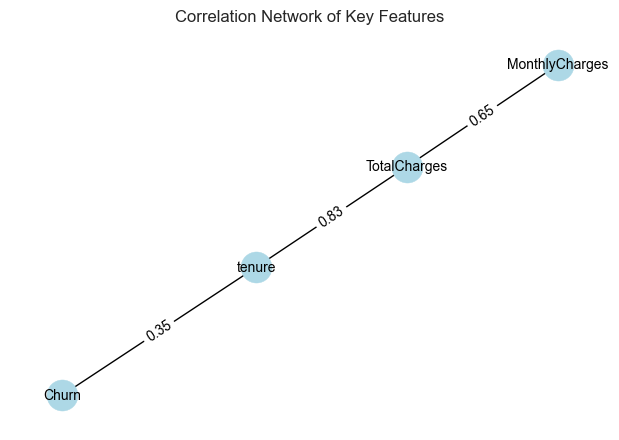

In [13]:
# Simple correlation network
G = nx.Graph()
features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']
corr_matrix = df[features].corr().abs()
for i, col1 in enumerate(features):
    for j, col2 in enumerate(features[i+1:], i+1):
        if corr_matrix.loc[col1, col2] > 0.3:  # Threshold for edge
            G.add_edge(col1, col2, weight=corr_matrix.loc[col1, col2])
plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'{d["weight"]:.2f}' for u, v, d in G.edges(data=True)})
plt.title('Correlation Network of Key Features')
plt.savefig('outputs/correlation_network.png', dpi=300)
plt.show()

In [14]:
# Save graph
nx.write_graphml(G, 'outputs/correlation_graph.graphml')

In [15]:
# Descriptive statistics
print("\nDescriptive Statistics (Post-Processing):")
print(df.describe())
df.describe().to_csv('outputs/descriptive_stats.csv')


Descriptive Statistics (Post-Processing):
            gender  SeniorCitizen      Partner   Dependents       tenure  \
count  7043.000000    7043.000000  7043.000000  7043.000000  7043.000000   
mean      0.504756       0.162147     0.483033     0.299588    32.371149   
std       0.500013       0.368612     0.499748     0.458110    24.559481   
min       0.000000       0.000000     0.000000     0.000000     0.000000   
25%       0.000000       0.000000     0.000000     0.000000     9.000000   
50%       1.000000       0.000000     0.000000     0.000000    29.000000   
75%       1.000000       0.000000     1.000000     1.000000    55.000000   
max       1.000000       1.000000     1.000000     1.000000    72.000000   

       PhoneService  MultipleLines  InternetService  OnlineSecurity  \
count   7043.000000    7043.000000      7043.000000     7043.000000   
mean       0.903166       0.940508         0.872923        0.790004   
std        0.295752       0.948554         0.737796        

___
# Visualizations
___

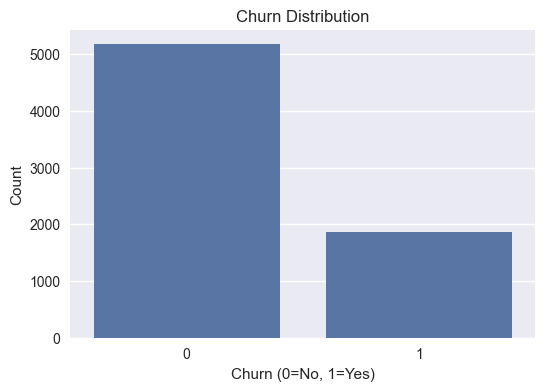

In [16]:
# Churn distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.xlabel('Churn (0=No, 1=Yes)')
plt.ylabel('Count')
plt.savefig('outputs/churn_distribution.png', dpi=300)
plt.show()

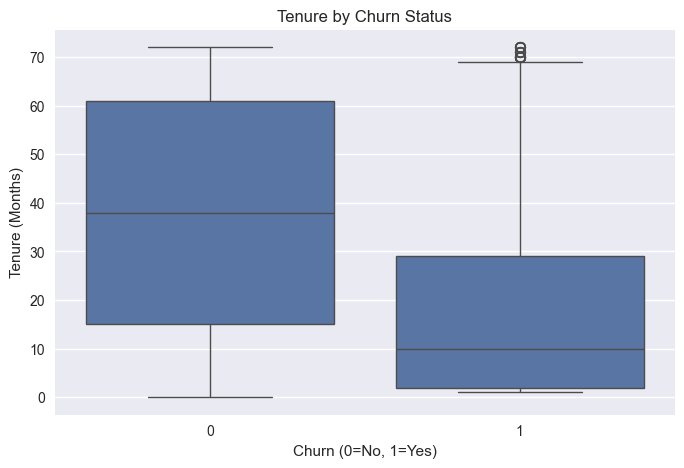

In [17]:
# Tenure vs Churn boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Tenure by Churn Status')
plt.xlabel('Churn (0=No, 1=Yes)')
plt.ylabel('Tenure (Months)')
plt.savefig('outputs/tenure_vs_churn.png', dpi=300)
plt.show()

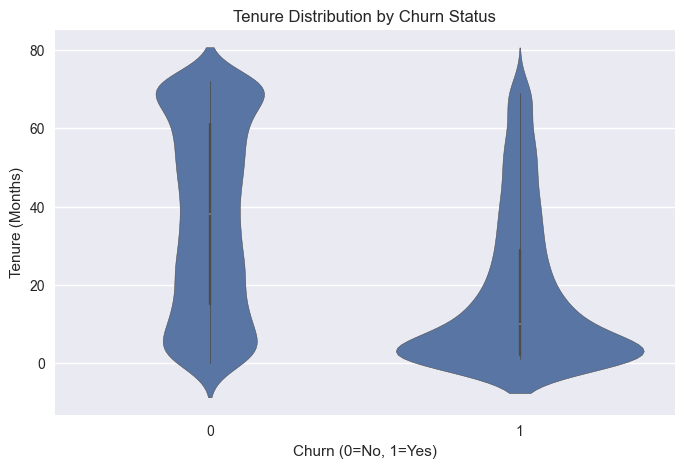

In [18]:
# Violin plot for tenure by churn
plt.figure(figsize=(8, 5))
sns.violinplot(x='Churn', y='tenure', data=df)
plt.title('Tenure Distribution by Churn Status')
plt.xlabel('Churn (0=No, 1=Yes)')
plt.ylabel('Tenure (Months)')
plt.savefig('outputs/tenure_violin.png', dpi=300)
plt.show()

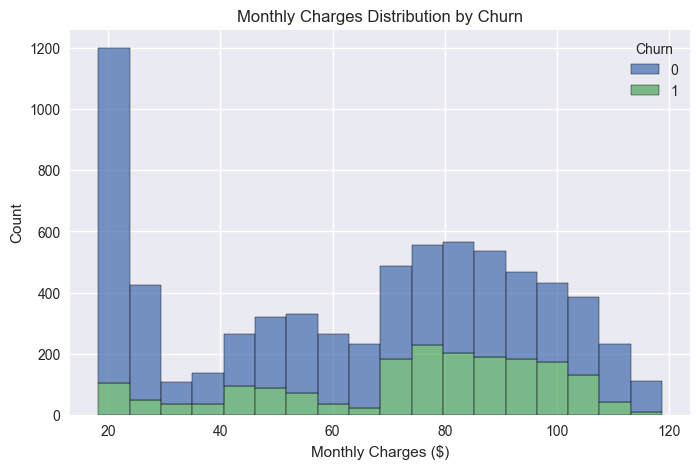

In [19]:
# MonthlyCharges distribution by Churn
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', multiple='stack')
plt.title('Monthly Charges Distribution by Churn')
plt.xlabel('Monthly Charges ($)')
plt.ylabel('Count')
plt.savefig('outputs/monthly_charges_dist.png', dpi=300)
plt.show()


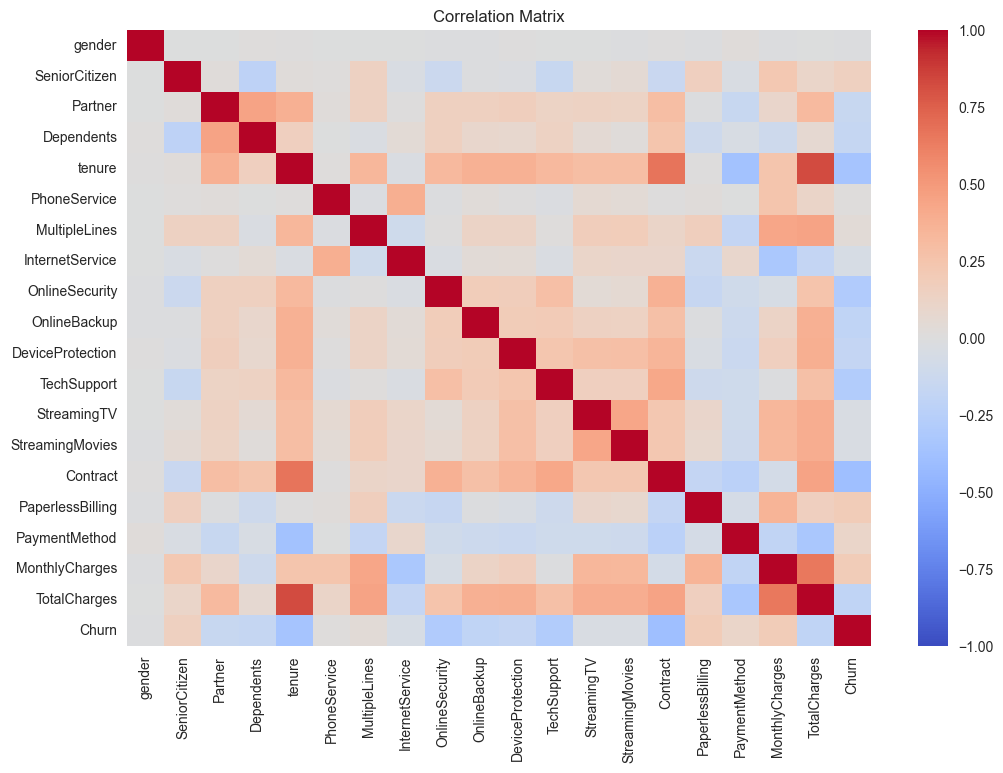

In [20]:
# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.savefig('outputs/correlation_matrix.png', dpi=300)
plt.show()

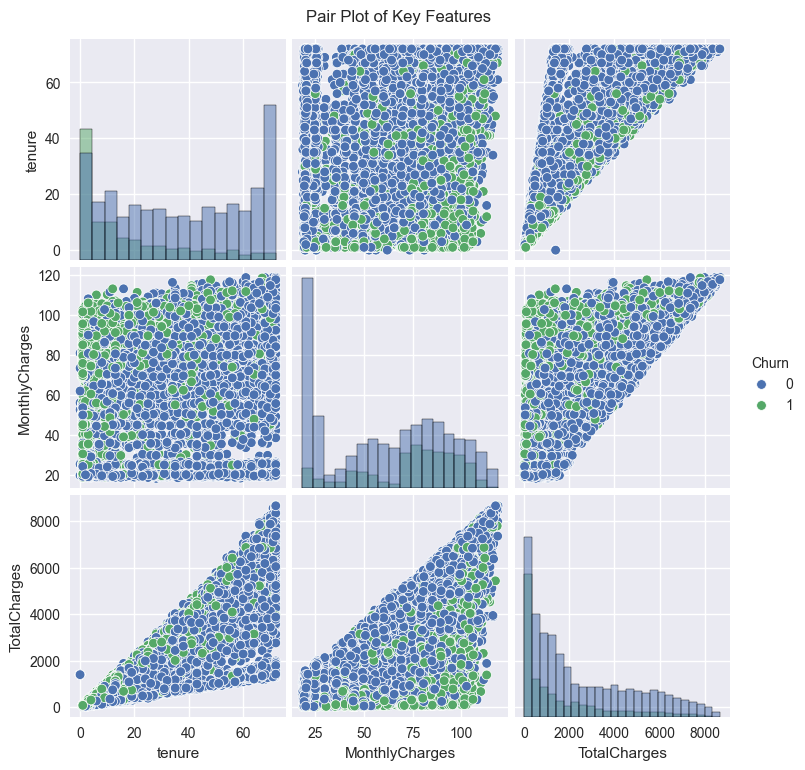

In [21]:
# Pair plot for key features
key_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']
sns.pairplot(df[key_features], hue='Churn', diag_kind='hist')
plt.suptitle('Pair Plot of Key Features', y=1.02)
plt.savefig('outputs/pair_plot.png', dpi=300)
plt.show()

___
# 3. Feature Engineering
___

# Objective:
- Create new features: tenure-to-charge ratio, service count, contract-tenure interaction.
- Select features using correlation threshold (<0.05).
- Standardize numerical features.
- Output proofs to support feature engineering discussion in the report.

In [22]:
# Create new features
df['Tenure_per_Charge'] = df['tenure'] / (df['MonthlyCharges'] + 1e-6)
df['Service_Count'] = df[['PhoneService', 'InternetService', 'StreamingTV', 'StreamingMovies']].sum(axis=1)
df['Contract_Tenure'] = df['Contract'] * df['tenure']

In [23]:
# Feature selection: Drop low-correlation features
corr_with_churn = df.corr()['Churn'].abs().sort_values()
low_corr_features = corr_with_churn[corr_with_churn < 0.05].index
print("\nDropped Low-Correlation Features:", low_corr_features)
df.drop(low_corr_features, axis=1, inplace=True, errors='ignore')


Dropped Low-Correlation Features: Index(['gender', 'PhoneService', 'StreamingTV', 'MultipleLines',
       'StreamingMovies', 'InternetService'],
      dtype='object')


In [24]:
# Prepare features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

In [25]:
# Standardize numerical features
scaler = StandardScaler()
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Tenure_per_Charge', 'Service_Count', 'Contract_Tenure']
X[num_cols] = scaler.fit_transform(X[num_cols])

In [26]:
# Simple associative classifier
X_binary = X[['tenure', 'MonthlyCharges', 'Contract', 'TotalCharges']].copy()
for col in X_binary.columns:
    X_binary[col] = (X_binary[col] > X_binary[col].median()).astype(int)
X_binary['Churn'] = y
frequent_itemsets = apriori(X_binary, min_support=0.1, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
rules = rules[rules['consequents'].apply(lambda x: 'Churn' in x)]
print("\nTop 5 Associative Rules for Churn:")
print(rules[['antecedents', 'consequents', 'support', 'confidence']].head())
rules.to_csv('outputs/associative_rules.csv', index=False)


Top 5 Associative Rules for Churn:
Empty DataFrame
Columns: [antecedents, consequents, support, confidence]
Index: []


c:\devtools\customer_churn\.venv\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [27]:
# Save processed data
X.to_csv('outputs/processed_features.csv', index=False)

___
# 4. Methodology & Algorithm Selection
___

# Objective:
- Models: Decision Tree, Random Forest, Logistic Regression.
- K-Means with 3 clusters for segmentation.
- GridSearchCV for parameter tuning.
- Stratified split handles imbalance (26% churn).

In [28]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [29]:
# K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
X_train['Cluster'] = kmeans.fit_predict(X_train[num_cols])
X_test['Cluster'] = kmeans.predict(X_test[num_cols])

In [30]:
# Define models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

In [31]:
# Hyperparameter grids
param_grids = {
    'Decision Tree': {'max_depth': [3, 5, 7], 'min_samples_split': [5, 10]},
    'Random Forest': {'n_estimators': [50, 100], 'max_depth': [3, 5]},
    'Logistic Regression': {'C': [0.1, 1, 10]}
}

___
# 5. Implementation & Results
___

# Objective:
- Implements models with scikit-learn, tuned via GridSearchCV.
- Metrics: accuracy, precision, recall, F1 Score, AUC for imbalance.
- Visualizations: confusion matrices, ROC curves, feature importance.
- Save outputs.


Tuning Decision Tree...

Decision Tree Results:
Accuracy: 0.7800
Precision: 0.5982
Recall: 0.5214
F1-Score: 0.5571

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.83      0.87      0.85      1035
       Churn       0.60      0.52      0.56       374

    accuracy                           0.78      1409
   macro avg       0.72      0.70      0.71      1409
weighted avg       0.77      0.78      0.77      1409



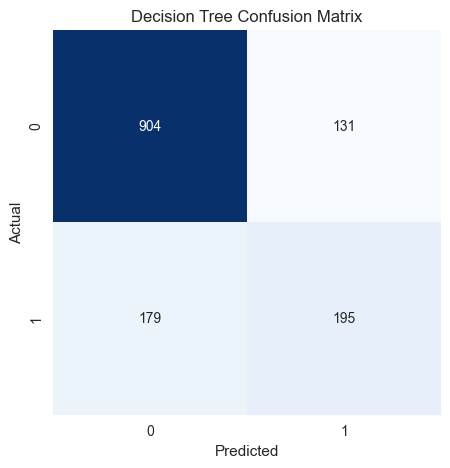

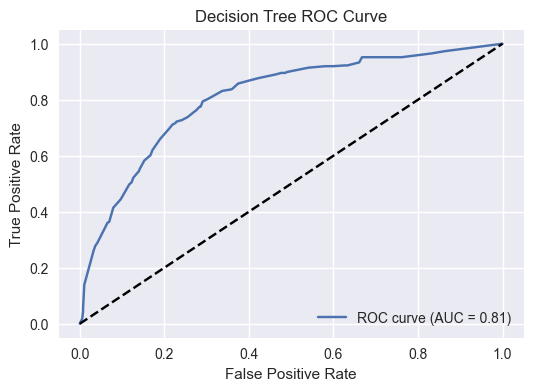

Best Parameters for Decision Tree: {'max_depth': 7, 'min_samples_split': 10}

Tuning Random Forest...

Random Forest Results:
Accuracy: 0.7906
Precision: 0.6561
Recall: 0.4439
F1-Score: 0.5295

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.82      0.92      0.87      1035
       Churn       0.66      0.44      0.53       374

    accuracy                           0.79      1409
   macro avg       0.74      0.68      0.70      1409
weighted avg       0.78      0.79      0.78      1409



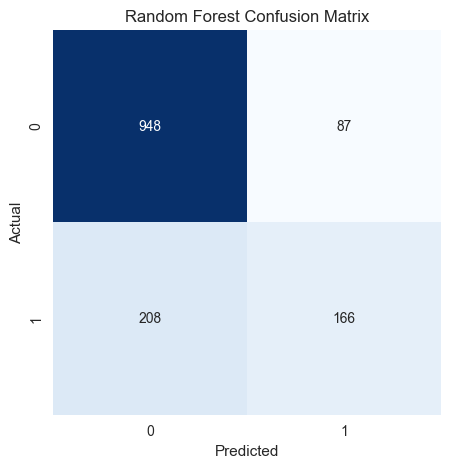

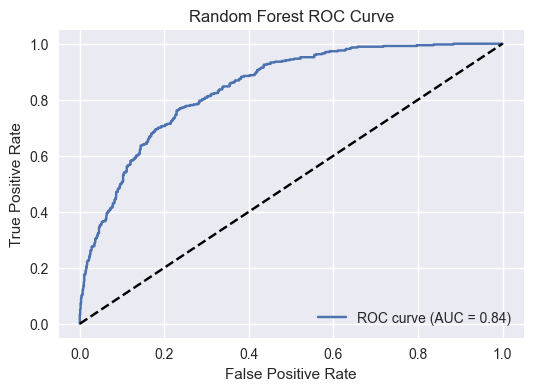

Best Parameters for Random Forest: {'max_depth': 5, 'n_estimators': 50}

Tuning Logistic Regression...

Logistic Regression Results:
Accuracy: 0.7935
Precision: 0.6317
Recall: 0.5321
F1-Score: 0.5776

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.84      0.89      0.86      1035
       Churn       0.63      0.53      0.58       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409



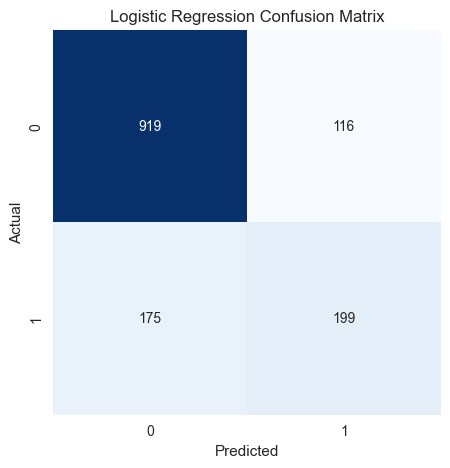

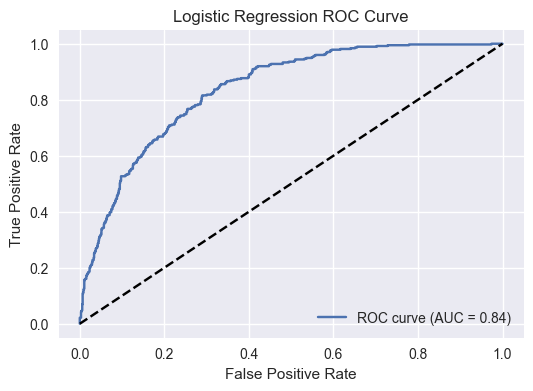

Best Parameters for Logistic Regression: {'C': 10}


In [32]:
# Function to train and evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }
    
    # Print results
    print(f"\n{model_name} Results:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'outputs/{model_name.lower().replace(" ", "_")}_cm.png', dpi=300)
    plt.show()
    
    # ROC curve
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'{model_name} ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.savefig(f'outputs/{model_name.lower().replace(" ", "_")}_roc.png', dpi=300)
        plt.show()
        metrics['AUC'] = roc_auc
    
    return metrics, model

# Train and evaluate with hyperparameter tuning
results = {}
best_models = {}
for name, model in models.items():
    print(f"\nTuning {name}...")
    grid = GridSearchCV(model, param_grids[name], cv=5, scoring='f1', n_jobs=-1)
    metrics, trained_model = evaluate_model(grid, X_train, X_test, y_train, y_test, name)
    results[name] = metrics
    best_models[name] = trained_model
    print(f"Best Parameters for {name}: {grid.best_params_}")

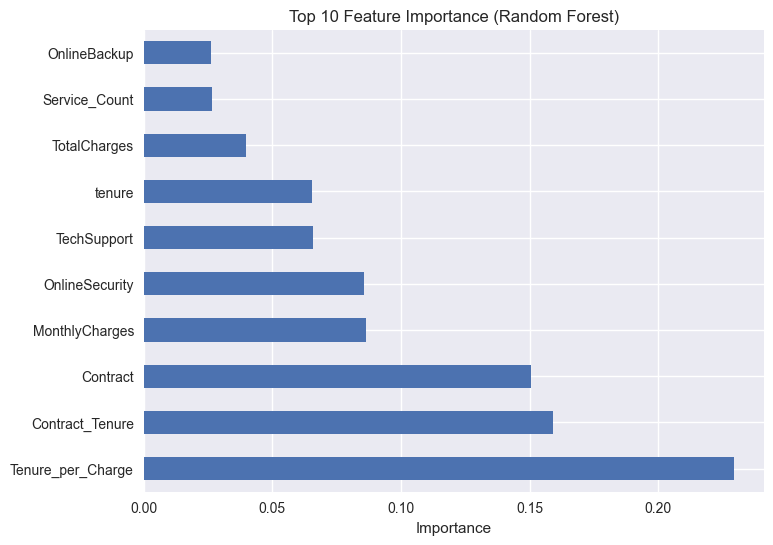

In [33]:
# Feature importance (Random Forest)
feature_importance = pd.Series(best_models['Random Forest'].best_estimator_.feature_importances_, index=X_train.columns)
plt.figure(figsize=(8, 6))
feature_importance.sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Top 10 Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.savefig('outputs/feature_importance.png', dpi=300)
plt.show()

___
# 6. Evaluation & Comparison of Approaches
___

# Objective:
- Compare models across metrics, including AUC.
- Cross-validation to assess stability.
- Output to support evaluation section in report.

In [34]:
# Compile results
comparison_df = pd.DataFrame({
    'Metric': results['Decision Tree'].keys(),
    **{name: [metrics[m] for m in metrics] for name, metrics in results.items()}
})

print("\nModel Comparison:")
print(comparison_df)
comparison_df.to_csv('outputs/model_comparison.csv', index=False)


Model Comparison:
      Metric  Decision Tree  Random Forest  Logistic Regression
0   Accuracy       0.779986       0.790632             0.793471
1  Precision       0.598160       0.656126             0.631746
2     Recall       0.521390       0.443850             0.532086
3   F1-Score       0.557143       0.529506             0.577649
4        AUC       0.808524       0.842437             0.836808


In [35]:
# Cross-validation
cv_results = {}
for name, model in best_models.items():
    cv_scores = cross_val_score(model.best_estimator_, X, y, cv=5, scoring='f1')
    cv_results[name] = {'Mean F1': cv_scores.mean(), 'Std F1': cv_scores.std()}
    print(f"\n{name} Cross-Validation F1: Mean={cv_scores.mean():.4f}, Std={cv_scores.std():.4f}")


Decision Tree Cross-Validation F1: Mean=0.5352, Std=0.0326

Random Forest Cross-Validation F1: Mean=0.5481, Std=0.0281

Logistic Regression Cross-Validation F1: Mean=0.5887, Std=0.0199


In [36]:
# Save CV results
pd.DataFrame(cv_results).to_csv('outputs/cv_results.csv')

In [37]:
# Save final dataset
df.to_csv('outputs/processed_churn_data.csv', index=False)